In [1]:
include("../src/Hydro.jl")

Main.Hydro

In [2]:
using .Hydro
using CSV
using DataFrames
using Printf: @sprintf

# Load some data

In [3]:
# load a test dataset from a CSV file into a dataframe
df = CSV.read("../test/data/test_2_data.csv", header=1, missingstrings=["-9999"])

,date,obs_rain,obs_pet,obs_runoff,test_sim_runoff
,Dates…⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,1978-01-01,0.16,5.814,0.276078,0.109251
2,1978-01-02,0.3,5.799,0.200986,0.10773
3,1978-01-03,0.52,5.783,0.158098,0.106904
4,1978-01-04,0.77,5.767,0.148447,0.106089
5,1978-01-05,4.17,5.751,0.130538,0.105285
6,1978-01-06,11.11,5.736,0.115582,0.108447
7,1978-01-07,14.2,5.72,0.110331,0.13595
8,1978-01-08,4.74,5.704,0.0977979,0.168004
9,1978-01-09,0.98,5.689,0.0905481,0.12436


In [ ]:
# rename the columns
names!(df, Symbol.(["date", "obs_rain", "obs_pet", "obs_runoff", "test_sim_runoff"]))

In [7]:
# Create a dictionary of data from the dataframe - standard data structure through Hydro
data = Dict()
data["rain"] = df[:obs_rain]
data["pet"] = df[:obs_pet]
data["runoff_obs"] = df[:obs_runoff]
data["runoff_sim_test"] = df[:test_sim_runoff];

# Calibrate GR4J parameters

In [8]:
# build up dictionary of model functions needed for calibration
functions = Dict()
functions["run_model_time_step"] = gr4j_run_step
functions["init_state"] = gr4j_init_state
functions["params_from_array"] = gr4j_params_from_array
functions["objective_function"] = (obs, sim) -> -1 * nse(obs, sim)
functions["params_inverse_transform"] = gr4j_params_trans_inv
functions["params_range_transform"] = gr4j_params_range_trans
functions["params_range_to_tuples"] = gr4j_params_range_to_tuples

gr4j_params_range_to_tuples (generic function with 1 method)

In [36]:
# find an optimial parameter set using NSE as the objective function
# with adaptive differential evolution method for 1000 iterations
opt_pars, opt_nse = calibrate(functions, data, gr4j_params_range(), 500, :de_rand_1_bin)
opt_nse *= -1

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.SimpleSelector,BlackBoxOptim.DiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.92 secs, 4 evals, 2 steps, fitness=0.040216044
1.82 secs, 8 evals, 4 steps, improv/step: 0.500 (last = 1.0000), fitness=-0.765916860
2.72 secs, 12 evals, 6 steps, improv/step: 0.500 (last = 0.5000), fitness=-0.765916860
3.55 secs, 16 evals, 8 steps, improv/step: 0.375 (last = 0.0000), fitness=-0.765916860
4.44 secs, 20 evals, 10 steps, improv/step: 0.300 (last = 0.0000), fitness=-0.765916860
5.30 secs, 24 evals, 12 steps, improv/step: 0.250 (last = 0.0000), fitness=-0.765916860
6.16 secs, 28 evals, 14 steps, improv/step: 0.286 (last = 0.5000), fitness=-0.765916860
6.79 secs, 31 evals, 16 steps, improv/step: 0.313 (last = 0.5000), fitness=-0.765916860
7.69 secs, 35 evals, 18 steps, improv/step: 0.333 (last = 0.5000), fitness=-0.76591686

65.75 secs, 302 evals, 215 steps, improv/step: 0.358 (last = 0.0000), fitness=-0.765916860
66.61 secs, 306 evals, 218 steps, improv/step: 0.362 (last = 0.6667), fitness=-0.765916860
67.49 secs, 310 evals, 220 steps, improv/step: 0.359 (last = 0.0000), fitness=-0.765916860
68.14 secs, 313 evals, 223 steps, improv/step: 0.368 (last = 1.0000), fitness=-0.765916860
68.79 secs, 316 evals, 226 steps, improv/step: 0.363 (last = 0.0000), fitness=-0.765916860
69.43 secs, 319 evals, 229 steps, improv/step: 0.358 (last = 0.0000), fitness=-0.765916860
70.05 secs, 322 evals, 232 steps, improv/step: 0.353 (last = 0.0000), fitness=-0.765916860
70.67 secs, 325 evals, 234 steps, improv/step: 0.355 (last = 0.5000), fitness=-0.765916860
71.28 secs, 328 evals, 236 steps, improv/step: 0.352 (last = 0.0000), fitness=-0.765916860
72.12 secs, 332 evals, 239 steps, improv/step: 0.351 (last = 0.3333), fitness=-0.765916860
72.76 secs, 335 evals, 242 steps, improv/step: 0.347 (last = 0.0000), fitness=-0.765916860

0.8105696624146396

In [69]:
# test parameters were
gr4j_params_from_array(CSV.read("../test/data/test_2_params.csv", delim=":", header=0)[2])

Dict{String,Float64} with 4 entries:
  "x1" => 55.0616
  "x4" => 1.49495
  "x2" => -0.039867
  "x3" => 249.783

In [71]:
# optimised parameters
opt_pars

Dict{String,Float64} with 4 entries:
  "x1" => 7.22978
  "x4" => 1.43886
  "x2" => -1.3244
  "x3" => 325.709

# Simulate using these calibrated parameters

In [44]:
opt_pars

Dict{String,Float64} with 4 entries:
  "x1" => 7.22978
  "x4" => 1.43886
  "x2" => -1.3244
  "x3" => 325.709

In [45]:
init_state = gr4j_init_state(opt_pars)

Dict{String,Any} with 6 entries:
  "uh2"              => [0.0, 0.0, 0.0, 0.0]
  "production_store" => 0
  "uh2_ordinates"    => [0.201339, 0.653348, 0.145313, 0.0]
  "routing_store"    => 0
  "uh1"              => [0.0, 0.0]
  "uh1_ordinates"    => [0.402677, 0.597323]

In [46]:
data = simulate(gr4j_run_step, data, opt_pars, init_state);

In [47]:
keys(data)

Base.KeySet for a Dict{Any,Any} with 5 entries. Keys:
  "runoff_sim"
  "pet"
  "rain"
  "runoff_obs"
  "runoff_sim_test"

# Plot a hydrograph of this simulation with test simulation

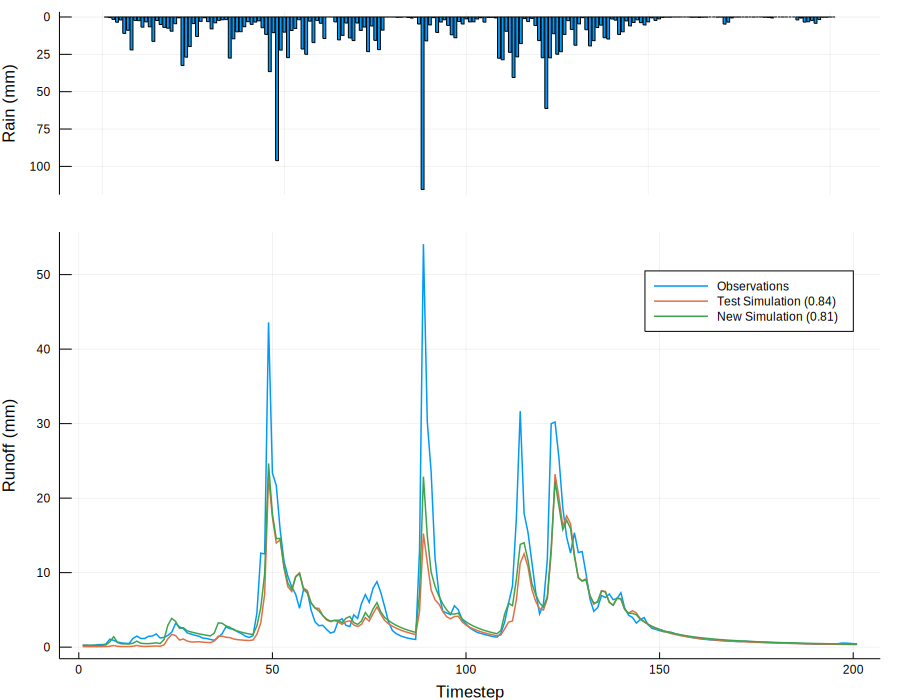

In [65]:
s, e = 12000, 12200

obs = data["runoff_obs"][s:e]
test = data["runoff_sim_test"][s:e]
sim = data["runoff_sim"][s:e]
rain = data["rain"][s:e]

nse_test = @sprintf("%.2f", nse(data["runoff_obs"], data["runoff_sim_test"]))
nse_sim = @sprintf("%.2f", nse(data["runoff_obs"], data["runoff_sim"]))

hydrograph(rain, [obs, test, sim], ["Observations", "Test Simulation ($nse_test)", "New Simulation ($nse_sim)"])